## 고양이 스티커 붙이기
### 순서
#### 본론
1. 필요한 모듈 import
2. 사진 불러오기
3. 얼굴 찾기
4. 얼굴 랜드마크 찾기
5. 스티커 불러오기
6. 영역 계산
7. 사진에 적용

#### 결론
1. 회고

## 본론
### 1. 필요한 모듈 import

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
print("🌫🛸")

🌫🛸


### 2. 사진 불러오기

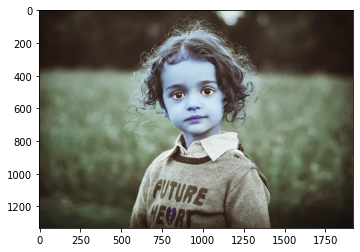

In [2]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/child.jpg'
img_bgr = cv2.imread(my_image_path)
# 출력용 이미지 별도 보관
img_show = img_bgr.copy()
plt.imshow(img_bgr)
plt.show()

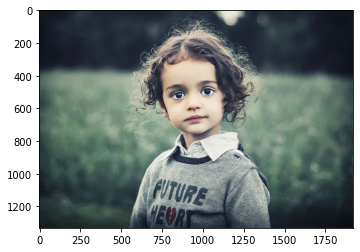

In [3]:
#RGB 값으로 변환
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

### 3. 얼굴 찾기

In [4]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector()
print("🌫🛸")

🌫🛸


In [5]:
# (image, num of image pyramid)
dlib_rects = detector_hog(img_show_rgb, 1)   
print(dlib_rects)

rectangles[[(760, 376) (1146, 761)]]


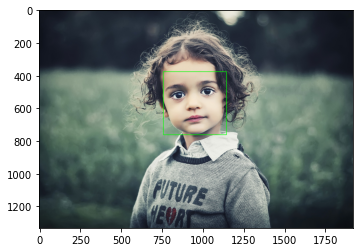

In [6]:
# 얼굴 찾기
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show_rgb, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
plt.imshow(img_show_rgb)
plt.show()

### 4. 얼굴 랜드마크 찾기

In [7]:
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
print("🌫🛸")

🌫🛸


In [8]:
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_show_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


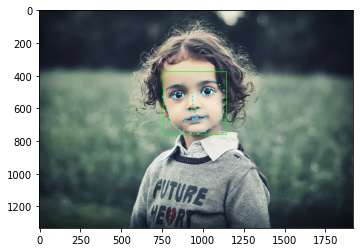

In [9]:
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show_rgb, point, 5, (0, 255, 255), -1)

plt.imshow(img_show_rgb)
plt.show()

In [10]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[33][0]
    y = landmark[33][1]
    w = h = dlib_rect.width()
    print('(x,y) : (%d,%d)'%(x,y))
    print('(w,h) : (%d,%d)'%(w,h))

(941, 576)
(x,y) : (948,613)
(w,h) : (387,387)


### 5. 스티커 불러오기

(387, 387, 3)


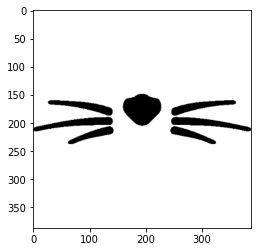

In [11]:
# 고양이 수염 사진 불러오기 - slack에서 공유받은 사진
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'

img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB))
plt.show()

### 6. 영역 계산

In [12]:
refined_x = x - img_sticker.shape[1] // 2  # left
refined_y = y + img_sticker.shape[0] // 2  # top
print (f'(x,y) : {refined_x, refined_y}')
if refined_y < 0 :
    img_sticker = img_sticker[-refined_y:]
    print (img_sticker.shape)
    refined_y = 0
    print (f'(x,y) : {refined_x, refined_y}')

(x,y) : (755, 806)


In [13]:
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (755,806)


In [17]:
# sticker 영역 구하기
sticker_area = img_show[refined_y-img_sticker.shape[0]:refined_y, refined_x:refined_x+img_sticker.shape[1]]

### 7. 사진에 적용

In [ ]:
# 원래 이미지의 스티커 영역에 스티커 붙히기
img_show[refined_y-img_sticker.shape[0]:refined_y, refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8) # np.where(조건, 맞을때 실행, 아닐때 실행)

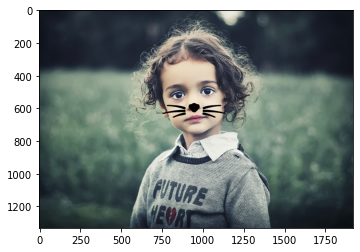

In [15]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

## 결론
### 1. 회고

불러온 스티커 이미지가 반전되는 이슈가 있었지만 이유를 알지 못하겠다. 코드 상엔 문제가 없어 보여서 내용을 비운 후 다시 입력해 실행해보니 해결되어 일단 넘어갔다.

이미지의 얼굴과 랜드마크를 찾아서 표시할 경우 그 표시가 계속 유지되기 때문에 얼굴, 랜드마크의 위치를 찾기 위한 이미지와 결과를 출력할 때 사용할 이미지를 구분해 놓는 것이 중요하다는 것을 알게 되었다. 그리고 이미지와 스티커의 shape가 다를 경우 적용이 안된다는 것도 알 수 있었다. 이는 브로드캐스팅 에러와 관련 있어 보인다.